In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import itertools
from sklearn import model_selection, ensemble, linear_model, metrics
from tqdm import tqdm
import re
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', 100)

## Загружаем данные

In [2]:
data_test= pd.read_csv('test.csv')
data_test = data_test.drop(['index'],axis = 1)
data_test.head()

,map_id,team1_id,team2_id,map_name
0,309,5973,5752,Dust2
1,541,5973,5752,Vertigo
2,1,8297,7020,Nuke
3,392,8297,7020,Mirage
4,684,8297,7020,Overpass


In [3]:
data_train= pd.read_csv('train.csv')
data_train

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1
...,...,...,...,...,...
708,709,6667,4773,Inferno,0
709,528,9215,5995,Ancient,1
710,163,4869,9565,Mirage,1
711,96,10426,4991,Nuke,1


0    0.541374
1    0.458626
Name: who_win, dtype: float64

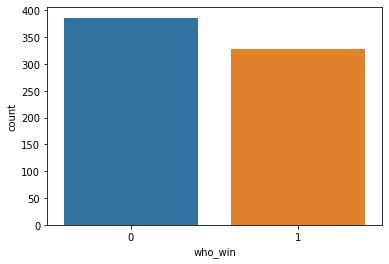

In [4]:
sns.countplot(x="who_win", data=data_train)  
data_train["who_win"].value_counts()/data_train.shape[0]

Классов примерно поровну

In [5]:
data_play= pd.read_csv('players_feats.csv')
data_play.head()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,...,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,0.24,0.72,0.13,0.05,0.98,0.80,0.58,62,-22,10,13,0.77,0.85,60.0,8.2,7412,106,35.8,119,0.89,66.8,5.6,7,181,0.59,0.09,0.66,0.07,0.06,0.91,0.89,0.59,75,-13,17,27,0.63,0.89,82.4,15.4,...,139,0.79,53.8,3.0,8,204,0.54,0.06,0.68,0.06,0.09,0.83,0.79,0.54,80,-29,15,20,0.75,0.87,53.3,8.2,15165,140,40.7,133,1.05,83.9,9.2,8,198,0.71,0.17,0.67,0.07,0.07,1.16,1.04,0.70,84,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,0.15,0.84,0.07,0.07,0.90,0.79,0.66,30,-12,5,10,0.50,0.79,40.0,10.0,5796,34,50.0,51,0.67,59.0,4.7,3,68,0.50,0.10,0.75,0.04,0.07,0.71,0.67,0.50,27,-17,5,4,1.25,0.94,0.0,0.0,...,53,0.51,50.4,5.3,3,68,0.40,0.04,0.78,0.01,0.03,0.56,0.51,0.40,22,-26,7,13,0.54,0.86,57.1,20.0,14932,504,55.0,370,1.36,85.8,3.9,23,599,0.84,0.12,0.62,0.08,0.12,1.28,1.36,0.86,233,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,0.10,0.63,0.11,0.11,0.95,0.93,0.59,107,-11,21,18,1.17,0.95,81.0,13.1,7412,125,35.2,135,0.93,68.7,5.7,8,211,0.59,0.13,0.64,0.07,0.07,0.98,0.93,0.59,91,-10,29,25,1.16,1.16,69.0,20.0,...,168,1.05,62.1,2.7,11,292,0.60,0.09,0.58,0.06,0.05,1.00,1.05,0.60,122,8,27,20,1.35,1.01,59.3,11.3,15165,166,34.9,144,1.15,86.8,12.2,8,226,0.73,0.20,0.64,0.08,0.11,1.19,1.15,0.73,116,22,26,19,1.37,1.10,88.5,20.5,6665,Dust2,583
3,5794,449,53.5,427,1.05,86.7,13.1,23,618,0.73,0.18,0.69,0.11,0.12,1.16,1.04,0.72,267,18,53,54,0.98,0.96,83.0,14.1,5796,353,59.5,377,0.94,63.4,4.2,23,618,0.57,0.11,0.61,0.10,0.08,0.98,0.95,0.58,249,-18,44,73,0.60,0.83,65.9,9.3,...,419,0.97,70.1,3.2,23,618,0.66,0.10,0.68,0.11,0.08,1.02,0.96,0.65,262,-17,60,66,0.91,0.99,75.0,14.5,14932,569,58.7,439,1.30,83.2,2.8,27,709,0.80,0.13,0.62,0.09,0.14,1.24,1.33,0.81,276,104,62,49,1.27,1.10,79.0,17.4,7532,Dust2,583
4,7998,173,32.9,130,1.33,82.4,2.9,9,225,0.77,0.12,0.58,0.08,0.08,1.29,1.33,0.77,120,43,41,17,2.41,1.45,82.9,25.0,8918,171,50.3,133,1.29,80.9,5.9,9,225,0.76,0.16,0.59,0.13,0.08,1.21,1.29,0.

In [6]:
data_test.isna().sum().sum(),data_train.isna().sum().sum(),data_play.isna().sum().sum()

(0, 0, 18)

Пропущенные значения, есть только в data_play

Создадим функцию, которая мержит таблицы

In [7]:
def merge_data_play(data,data_play,team_number):
    info_team_1 = data[['map_id',f'team{team_number}_id']]
    info_team_1.columns = ['map_id','team_id']
    info_team_1 = info_team_1.merge(data_play, on = ['map_id','team_id'],how = 'inner')
    info_team_1 = info_team_1.add_suffix(f'_{team_number}')
    info_team_1 = info_team_1.rename(columns={f"map_id_{team_number}": "map_id",f"team_id_{team_number}":f"team{team_number}_id"})
    info_team_1 = info_team_1.drop([f'map_name_{team_number}'],axis = 1)
    return info_team_1

In [8]:
train_team_1 = merge_data_play(data_train,data_play,'1')
train_team_2 = merge_data_play(data_train,data_play,'2')
train_team_1.head()

,map_id,team1_id,p1_id_1,p1_total_kills_1,p1_headshots_1,p1_total_deaths_1,p1_kd_ratio_1,p1_damage_per_round_1,p1_grenade_damage_per_round_1,p1_maps_played_1,p1_rounds_played_1,p1_kills_per_round_1,p1_assists_per_round_1,p1_deaths_per_round_1,p1_saved_by_teammate_per_round_1,p1_saved_teammates_per_round_1,p1_rating_1,p1_kill_death_1,p1_kill_round_1,p1_rounds_with_kills_1,p1_kill_death_difference_1,p1_total_opening_kills_1,p1_total_opening_deaths_1,p1_opening_kill_ratio_1,p1_opening_kill_rating_1,p1_team_win_percent_after_first_kill_1,p1_first_kill_in_won_rounds_1,p2_id_1,p2_total_kills_1,p2_headshots_1,p2_total_deaths_1,p2_kd_ratio_1,p2_damage_per_round_1,p2_grenade_damage_per_round_1,p2_maps_played_1,p2_rounds_played_1,p2_kills_per_round_1,p2_assists_per_round_1,p2_deaths_per_round_1,p2_saved_by_teammate_per_round_1,p2_saved_teammates_per_round_1,p2_rating_1,p2_kill_death_1,p2_kill_round_1,p2_rounds_with_kills_1,p2_kill_death_difference_1,p2_total_opening_kills_1,p2_total_opening_deaths_1,p2_opening_kill_ratio_1,p2_opening_kill_rating_1,...,p4_id_1,p4_total_kills_1,p4_headshots_1,p4_total_deaths_1,p4_kd_ratio_1,p4_damage_per_round_1,p4_grenade_damage_per_round_1,p4_maps_played_1,p4_rounds_played_1,p4_kills_per_round_1,p4_assists_per_round_1,p4_deaths_per_round_1,p4_saved_by_teammate_per_round_1,p4_saved_teammates_per_round_1,p4_rating_1,p4_kill_death_1,p4_kill_round_1,p4_rounds_with_kills_1,p4_kill_death_difference_1,p4_total_opening_kills_1,p4_total_opening_deaths_1,p4_opening_kill_ratio_1,p4_opening_kill_rating_1,p4_team_win_percent_after_first_kill_1,p4_first_kill_in_won_rounds_1,p5_id_1,p5_total_kills_1,p5_headshots_1,p5_total_deaths_1,p5_kd_ratio_1,p5_damage_per_round_1,p5_grenade_damage_per_round_1,p5_maps_played_1,p5_rounds_played_1,p5_kills_per_round_1,p5_assists_per_round_1,p5_deaths_per_round_1,p5_saved_by_teammate_per_round_1,p5_saved_teammates_per_round_1,p5_rating_1,p5_kill_death_1,p5_kill_round_1,p5_rounds_with_kills_1,p5_kill_death_difference_1,p5_total_opening_kills_1,p5_total_opening_deaths_1,p5_opening_kill_ratio_1,p5_opening_kill_rating_1,p5_team_win_percent_after_first_kill_1,p5_first_kill_in_won_rounds_1
0,289,6665,4954,258,36.0,293,0.88,71.1,6.3,17,454,0.57,0.20,0.65,0.12,0.07,0.98,0.88,0.57,184,-35,32,39,0.82,0.88,71.9,9.5,7412,263,40.7,298,0.88,67.0,4.7,17,454,0.58,0.13,0.66,0.08,0.07,0.95,0.88,0.58,179,-35,42,55,0.76,0.93,...,13300,153,30.7,123,1.24,68.8,5.0,8,210,0.73,0.08,0.59,0.10,0.12,1.08,1.24,0.73,105,30,12,12,1.00,0.86,66.7,7.1,15165,318,36.8,263,1.21,81.4,8.1,16,431,0.74,0.14,0.61,0.06,0.11,1.19,1.21,0.74,210,55,55,33,1.67,1.18,83.6,19.7
1,715,4411,8611,178,39.3,208,0.86,64.1,6.5,12,320,0.56,0.14,0.65,0.09,0.10,0.94,0.86,0.56,133,-30,25,16,1.56,0.97,68.0,11.3,9278,277,49.8,293,0.95,68.1,5.4,17,443,0.63,0.13,0.66,0.13,0.12,1.00,0.95,0.63,186,-16,37,38,0.97,0.94,...,13666,224,58.9,220,1.02,80.9,10.9,13,343,0.65,0.15,0.64,0.11,0.09,1.15,1.02,0.65,148,4,60,52,1.15,1.29,75.0,23.2,14218,269,40.5,292,0.92,70.4,7.7,17,443,0.61,0.16,0.66,0.12,0.12,1.01,0.92,0.61,186,-23,47,49,0.96,1.01,74.5,16.3
2,157,11251,7938,494,52.8,397,1.24,94.0,5.8,22,596,0.83,0.16,0.67,0.11,0.08,1.31,1.09,0.76,198,26,82,46,1.78,1.51,80.5,32.4,8574,424,26.7,344,1.23,73.0,3.0,22,596,0.71,0.10,0.58,0.04,0.06,1.12,1.15,0.69,189,36,38,25,1.52,1.04,...,15835,422,55.0,399,1.06,76.6,2.8,22,596,0.71,0.11,0.67,0.11,0.10,1.12,0.99,0.68,181,-3,62,49,1.27,1.24,66.1,20.1,19187,305,43.3,270,1.13,71.4,5.4,17,458,0.67,0.12,0.59,0.07,0.10,1.06,1.04,0.64,150,8,11,21,0.52,0.73,81.8,5.0
3,524,4608,7998,474,29.1,304,1.56,86.9,2.4,18,531,0.89,0.09,0.57,0.06,0.10,1.36,1.56,0.89,290,170,74,36,2.06,1.25,74.3,18.6,8918,358,46.1,348,1.03,80.6,4.3,18,531,0.67,0.15,0.66,0.06,0.05,1.09,1.03,0.67,238,10,73,59,1.24,1.17,...,16947,272,49.3,302,0.90,57.2,3.9,18,531,0.51,0.10,0.57,0.08,0.06,0.92,0.90,0.51,204,-30,27,24,1.12,0.85,81.5,7.4,18987,396,64.6,330,1.20,82.6,5.3,18,531,0.75,0.14,0.62,0.07,0.08,1.19,1.20,0.75,261,66,74,57,1.30,1.18,81.1,20.3
4,404,8637,289

In [9]:
test_team_1 = merge_data_play(data_test,data_play,'1')
test_team_2 = merge_data_play(data_test,data_play,'2')

Функция финального мержа

In [10]:
def final_merge(data_train,team_1,team_2):
    final_data = team_1.merge(team_2,on = ['map_id'],how = 'inner')
    final_data = final_data.merge(data_train, on = ['map_id','team1_id','team2_id'],how = 'inner')
    return final_data

In [11]:
final_train = final_merge(data_train,train_team_1,train_team_2)
final_test = final_merge(data_test,test_team_1,test_team_2)
final_train.head()

,map_id,team1_id,p1_id_1,p1_total_kills_1,p1_headshots_1,p1_total_deaths_1,p1_kd_ratio_1,p1_damage_per_round_1,p1_grenade_damage_per_round_1,p1_maps_played_1,p1_rounds_played_1,p1_kills_per_round_1,p1_assists_per_round_1,p1_deaths_per_round_1,p1_saved_by_teammate_per_round_1,p1_saved_teammates_per_round_1,p1_rating_1,p1_kill_death_1,p1_kill_round_1,p1_rounds_with_kills_1,p1_kill_death_difference_1,p1_total_opening_kills_1,p1_total_opening_deaths_1,p1_opening_kill_ratio_1,p1_opening_kill_rating_1,p1_team_win_percent_after_first_kill_1,p1_first_kill_in_won_rounds_1,p2_id_1,p2_total_kills_1,p2_headshots_1,p2_total_deaths_1,p2_kd_ratio_1,p2_damage_per_round_1,p2_grenade_damage_per_round_1,p2_maps_played_1,p2_rounds_played_1,p2_kills_per_round_1,p2_assists_per_round_1,p2_deaths_per_round_1,p2_saved_by_teammate_per_round_1,p2_saved_teammates_per_round_1,p2_rating_1,p2_kill_death_1,p2_kill_round_1,p2_rounds_with_kills_1,p2_kill_death_difference_1,p2_total_opening_kills_1,p2_total_opening_deaths_1,p2_opening_kill_ratio_1,p2_opening_kill_rating_1,...,p4_headshots_2,p4_total_deaths_2,p4_kd_ratio_2,p4_damage_per_round_2,p4_grenade_damage_per_round_2,p4_maps_played_2,p4_rounds_played_2,p4_kills_per_round_2,p4_assists_per_round_2,p4_deaths_per_round_2,p4_saved_by_teammate_per_round_2,p4_saved_teammates_per_round_2,p4_rating_2,p4_kill_death_2,p4_kill_round_2,p4_rounds_with_kills_2,p4_kill_death_difference_2,p4_total_opening_kills_2,p4_total_opening_deaths_2,p4_opening_kill_ratio_2,p4_opening_kill_rating_2,p4_team_win_percent_after_first_kill_2,p4_first_kill_in_won_rounds_2,p5_id_2,p5_total_kills_2,p5_headshots_2,p5_total_deaths_2,p5_kd_ratio_2,p5_damage_per_round_2,p5_grenade_damage_per_round_2,p5_maps_played_2,p5_rounds_played_2,p5_kills_per_round_2,p5_assists_per_round_2,p5_deaths_per_round_2,p5_saved_by_teammate_per_round_2,p5_saved_teammates_per_round_2,p5_rating_2,p5_kill_death_2,p5_kill_round_2,p5_rounds_with_kills_2,p5_kill_death_difference_2,p5_total_opening_kills_2,p5_total_opening_deaths_2,p5_opening_kill_ratio_2,p5_opening_kill_rating_2,p5_team_win_percent_after_first_kill_2,p5_first_kill_in_won_rounds_2,map_name,who_win
0,289,6665,4954,258,36.0,293,0.88,71.1,6.3,17,454,0.57,0.20,0.65,0.12,0.07,0.98,0.88,0.57,184,-35,32,39,0.82,0.88,71.9,9.5,7412,263,40.7,298,0.88,67.0,4.7,17,454,0.58,0.13,0.66,0.08,0.07,0.95,0.88,0.58,179,-35,42,55,0.76,0.93,...,27.9,102,1.20,63.3,2.9,7,183,0.67,0.05,0.56,0.03,0.06,1.07,1.20,0.67,79,20,18,7,2.57,1.09,55.6,11.9,19509,101,47.5,135,0.75,65.6,5.0,7,183,0.55,0.16,0.74,0.16,0.04,0.88,0.75,0.55,75,-34,21,20,1.05,1.06,76.2,19.0,Ancient,0
1,715,4411,8611,178,39.3,208,0.86,64.1,6.5,12,320,0.56,0.14,0.65,0.09,0.10,0.94,0.86,0.56,133,-30,25,16,1.56,0.97,68.0,11.3,9278,277,49.8,293,0.95,68.1,5.4,17,443,0.63,0.13,0.66,0.13,0.12,1.00,0.95,0.63,186,-16,37,38,0.97,0.94,...,48.8,498,1.30,88.4,14.3,32,836,0.77,0.18,0.60,0.08,0.13,1.28,1.26,0.78,297,92,75,47,1.60,1.18,61.3,14.8,19069,459,25.7,341,1.35,74.0,4.9,24,623,0.74,0.11,0.55,0.09,0.08,1.24,1.43,0.78,197,90,64,25,2.56,1.39,75.0,23.3,Inferno,0
2,157,11251,7938,494,52.8,397,1.24,94.0,5.8,22,596,0.83,0.16,0.67,0.11,0.08,1.31,1.09,0.76,198,26,82,46,1.78,1.51,80.5,32.4,8574,424,26.7,344,1.23,73.0,3.0,22,596,0.71,0.10,0.58,0.04,0.06,1.12,1.15,0.69,189,36,38,25,1.52,1.04,...,32.8,208,0.97,69.8,5.4,13,337,0.60,0.19,0.62,0.10,0.08,1.03,0.97,0.62,109,-4,24,12,2.00,1.08,62.5,13.6,12822,238,40.3,223,1.07,77.2,4.1,13,337,0.71,0.15,0.66,0.07,0.09,1.14,0.81,0.55,101,-32,32,35,0.91,1.09,53.1,15.5,Nuke,1
3,524,4608,7998,474,29.1,304,1.56,86.9,2.4,18,531,0.89,0.09,0.57,0.06,0.10,1.36,1.56,0.89,290,170,74,36,2.06,1.25,74.3,18.6,8918,358,46.1,348,1.03,80.6,4.3,18,531,0.67,0.15,0.66,0.06,0.05,1.09,1.03,0.67,238,10,73,59,1.24,1.17,...,46.4,308,0.94,69.1,4.0,15,450,0.65,0.11,0.68,0.09,0.10,0.96,0.94,0.65,179,-16,26,37,0.70,0.83,57.7,7.5,19899,163,47.2,176,0.93,61.3,6.9,10,297,0.55,0.12,0.59,0.08,0.08,0.94,0.92,0.54,109,-13,15,21,0.71,0.82,73.3,7.9,Mirage,0
4,404,8637,2898,217,55.8,

Все размерности при мерже совпали

### Анализ переменных

Очевидно, что переменные, в которых содержится слово _id, нам не нужны.  
Конечно, можно было бы использовать переменную team_id одну или в связке с названием карты для определения винрейта команды на карте или в целом.   
Но если не заглядывать в будущее (сделать замену сейчас, а валидировать уже на замененных данных), то результат получится не очень, поэтому мы удалим эти переменные

In [12]:
col = final_train.columns.tolist()
regex = re.compile(r'_id')
col = [i for i in col if regex.search(i)]
col
# data_final_last = data_final[l]

['map_id',
 'team1_id',
 'p1_id_1',
 'p2_id_1',
 'p3_id_1',
 'p4_id_1',
 'p5_id_1',
 'team2_id',
 'p1_id_2',
 'p2_id_2',
 'p3_id_2',
 'p4_id_2',
 'p5_id_2']

Сохраним информацию о team1_id и team2_id (номера строк на которых они встречаются)

In [13]:
info_train = final_train[['team1_id','team2_id']]
info_test= final_test[['team1_id','team2_id']]

In [14]:
final_train = final_train.drop(col,axis = 1)
final_test = final_test.drop(col,axis = 1)

In [15]:
final_train.describe()

,p1_total_kills_1,p1_headshots_1,p1_total_deaths_1,p1_kd_ratio_1,p1_damage_per_round_1,p1_grenade_damage_per_round_1,p1_maps_played_1,p1_rounds_played_1,p1_kills_per_round_1,p1_assists_per_round_1,p1_deaths_per_round_1,p1_saved_by_teammate_per_round_1,p1_saved_teammates_per_round_1,p1_rating_1,p1_kill_death_1,p1_kill_round_1,p1_rounds_with_kills_1,p1_kill_death_difference_1,p1_total_opening_kills_1,p1_total_opening_deaths_1,p1_opening_kill_ratio_1,p1_opening_kill_rating_1,p1_team_win_percent_after_first_kill_1,p1_first_kill_in_won_rounds_1,p2_total_kills_1,p2_headshots_1,p2_total_deaths_1,p2_kd_ratio_1,p2_damage_per_round_1,p2_grenade_damage_per_round_1,p2_maps_played_1,p2_rounds_played_1,p2_kills_per_round_1,p2_assists_per_round_1,p2_deaths_per_round_1,p2_saved_by_teammate_per_round_1,p2_saved_teammates_per_round_1,p2_rating_1,p2_kill_death_1,p2_kill_round_1,p2_rounds_with_kills_1,p2_kill_death_difference_1,p2_total_opening_kills_1,p2_total_opening_deaths_1,p2_opening_kill_ratio_1,p2_opening_kill_rating_1,p2_team_win_percent_after_first_kill_1,p2_first_kill_in_won_rounds_1,p3_total_kills_1,p3_headshots_1,...,p3_first_kill_in_won_rounds_2,p4_total_kills_2,p4_headshots_2,p4_total_deaths_2,p4_kd_ratio_2,p4_damage_per_round_2,p4_grenade_damage_per_round_2,p4_maps_played_2,p4_rounds_played_2,p4_kills_per_round_2,p4_assists_per_round_2,p4_deaths_per_round_2,p4_saved_by_teammate_per_round_2,p4_saved_teammates_per_round_2,p4_rating_2,p4_kill_death_2,p4_kill_round_2,p4_rounds_with_kills_2,p4_kill_death_difference_2,p4_total_opening_kills_2,p4_total_opening_deaths_2,p4_opening_kill_ratio_2,p4_opening_kill_rating_2,p4_team_win_percent_after_first_kill_2,p4_first_kill_in_won_rounds_2,p5_total_kills_2,p5_headshots_2,p5_total_deaths_2,p5_kd_ratio_2,p5_damage_per_round_2,p5_grenade_damage_per_round_2,p5_maps_played_2,p5_rounds_played_2,p5_kills_per_round_2,p5_assists_per_round_2,p5_deaths_per_round_2,p5_saved_by_teammate_per_round_2,p5_saved_teammates_per_round_2,p5_rating_2,p5_kill_death_2,p5_kill_round_2,p5_rounds_with_kills_2,p5_kill_death_difference_2,p5_total_opening_kills_2,p5_total_opening_deaths_2,p5_opening_kill_ratio_2,p5_opening_kill_rating_2,p5_team_win_percent_after_first_kill_2,p5_first_kill_in_won_rounds_2,who_win
count,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.00000,713.000000,712.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,712.000000,713.000000,713.000000,713.000000,...,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.00000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,711.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,713.000000,710.000000,713.000000,713.000000
mean,240.831697,45.331276,244.827489,0.987826,72.181907,5.235344,13.917251,372.582048,0.640042,0.129411,0.646241,0.090435,0.079130,1.025428,0.937181,0.614278,141.475456,-7.646564,32.058906,33.814867,0.99662,0.951206,69.957584,13.498738,243.587658,45.727770,229.795231,1.053548,74.139411,4.944881,13.472651,360.457223,0.668485,0.127055,0.632917,0.089832,0.089832,1.065273,1.001865,0.641501,140.656381,7.628331,32.708275,30.910238,1.078247,0.980898,69.741573,14.080365,257.100982,46.178682,...,13.906311,250.527349,42.735484,223.471248,1.124278,73.796914,4.348808,13.43899,357.601683,0.691487,0.113969,0.618499,0.086129,0.094727,1.096087,1

Найдем корреляции для вещественных переменных

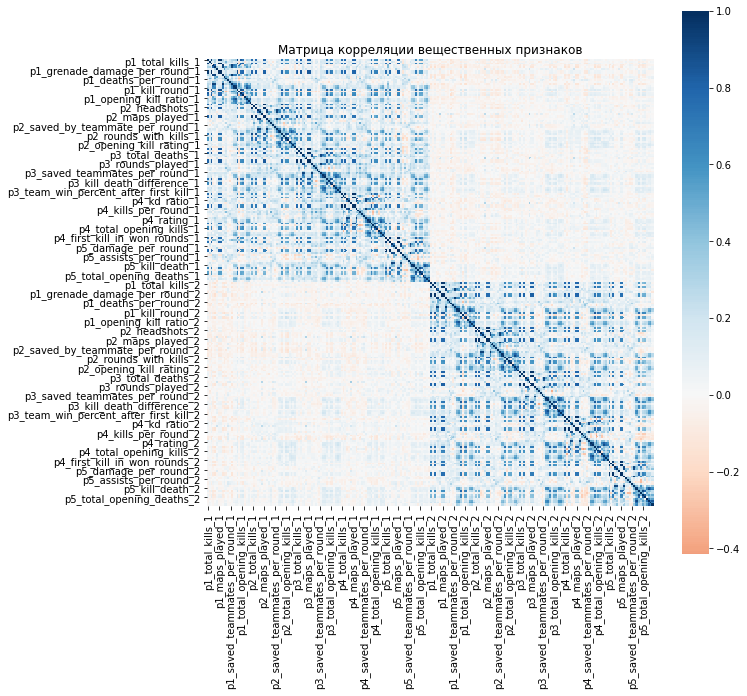

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(final_train.iloc[:,:-2].corr(),cmap="RdBu",center=0, square=True)
plt.title("Матрица корреляции вещественных признаков")
plt.show()

Здесь мы видим, четкое разбиение на группу информации о игроках первой команды и второй

Посмотрим какая информация у нас есть например по первому игроку

In [17]:
col = final_train.columns.tolist()
regex_1 = re.compile(r'_1')
regex_2 = re.compile(r'p1_')
col_1_player = [i for i in col if regex_1.search(i) and regex_2.match(i)]
col_1_player

['p1_total_kills_1',
 'p1_headshots_1',
 'p1_total_deaths_1',
 'p1_kd_ratio_1',
 'p1_damage_per_round_1',
 'p1_grenade_damage_per_round_1',
 'p1_maps_played_1',
 'p1_rounds_played_1',
 'p1_kills_per_round_1',
 'p1_assists_per_round_1',
 'p1_deaths_per_round_1',
 'p1_saved_by_teammate_per_round_1',
 'p1_saved_teammates_per_round_1',
 'p1_rating_1',
 'p1_kill_death_1',
 'p1_kill_round_1',
 'p1_rounds_with_kills_1',
 'p1_kill_death_difference_1',
 'p1_total_opening_kills_1',
 'p1_total_opening_deaths_1',
 'p1_opening_kill_ratio_1',
 'p1_opening_kill_rating_1',
 'p1_team_win_percent_after_first_kill_1',
 'p1_first_kill_in_won_rounds_1']

графики для первых игроков первой команды

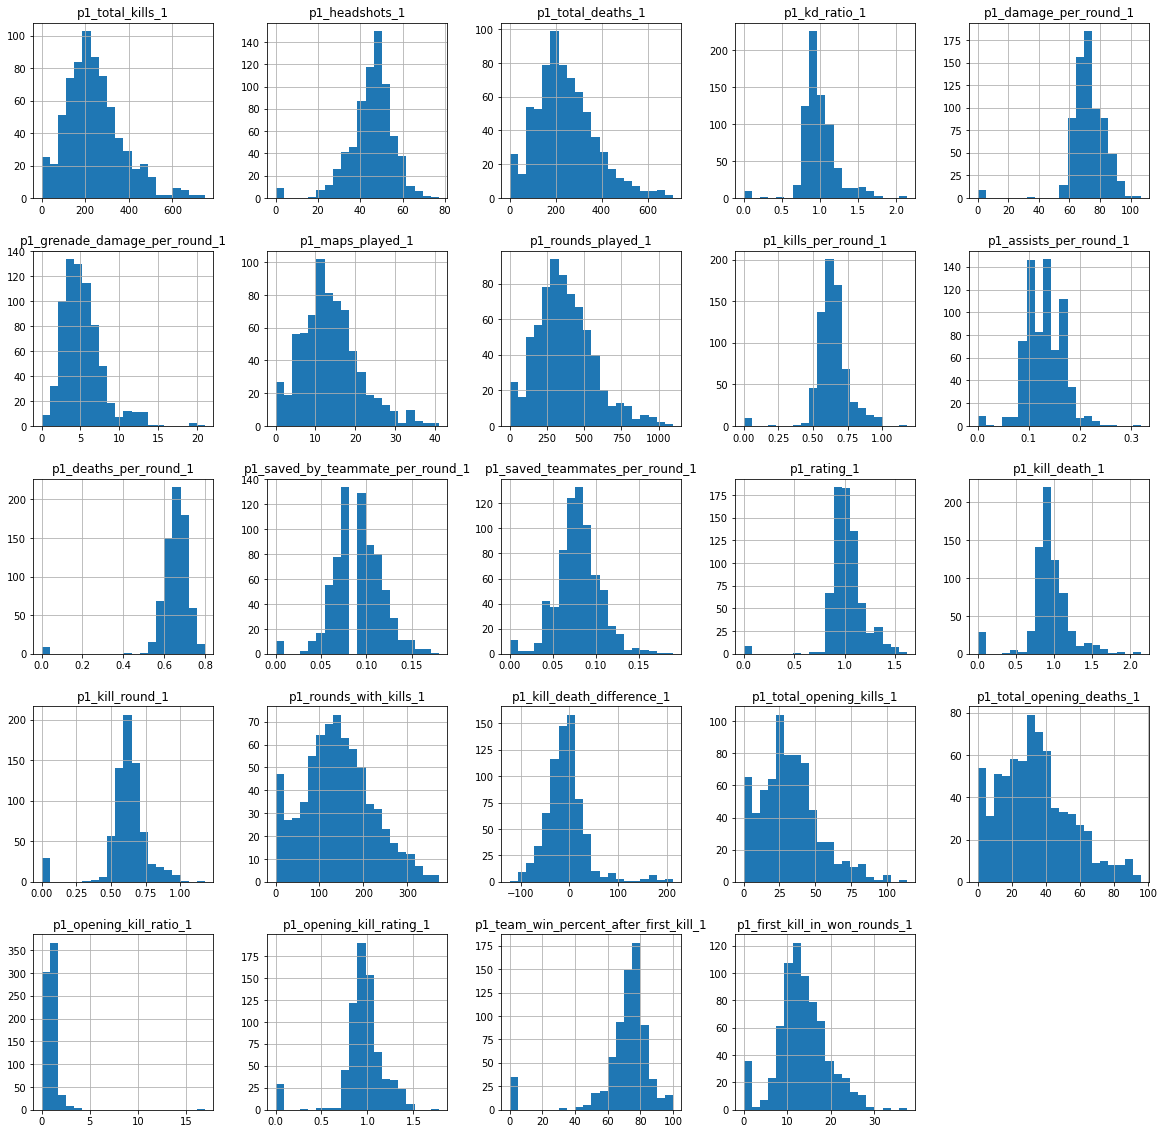

In [18]:
final_train[col_1_player].hist(figsize=(20, 20),bins=20);

Видно, что существуют значения, у которых вся инфа об игроке нулевая. Это значит что он проводит свой первый матч.  
Сложно анализировать команду, в которой есть игроки играющие первый матч.  
Если не заглядывать в будущее и не заменять эти значение средним, то их будет лучше удалить

Создадим функцию, которая будет находить игроков у которых 0 сыгранных карт

In [19]:
def zero_map(final_train):
    col_maps = final_train.columns.tolist()
    regex_1 = re.compile(r'_maps_played_')
    maps_ = [i for i in col if regex_1.search(i)]
    maps = final_train[maps_]
    zero = np.where(maps.applymap(lambda x: x == 0))
    zero_name = [maps_[i] for i in zero[1]]
    zero_maps = pd.DataFrame(zip(zero[0],zero_name),columns = ['index','name_player'])
    zero_maps['expand'] = zero_maps.apply(lambda x: ','.join([x['name_player']]), axis=1)
    zero_maps = pd.DataFrame(zero_maps.groupby('index')['expand'].apply(list)).reset_index()
    return zero_maps


In [20]:
zero_train = zero_map(final_train)
zero_train.head()

,index,expand
0,40,[p5_maps_played_1]
1,47,[p1_maps_played_1]
2,59,"[p2_maps_played_1, p3_maps_played_1, p4_maps_p..."
3,64,[p1_maps_played_1]
4,116,"[p2_maps_played_1, p3_maps_played_1, p4_maps_p..."


Найдем матчи, для которых больше, чем у одного игрока 0 сыгранных карт

In [21]:
zero_train['many'] = 0
for i in range(len(zero_train)):
     zero_train.loc[i,'many'] = len(zero_train.loc[i,'expand'])
zero_train_many = zero_train.loc[zero_train['many']>1]
zero_train_many

,index,expand,many
2,59,"[p2_maps_played_1, p3_maps_played_1, p4_maps_p...",4
4,116,"[p2_maps_played_1, p3_maps_played_1, p4_maps_p...",3
9,201,"[p1_maps_played_1, p2_maps_played_1, p3_maps_p...",5
10,214,"[p1_maps_played_1, p2_maps_played_1, p3_maps_p...",5
18,363,"[p2_maps_played_1, p4_maps_played_2]",2
20,423,"[p1_maps_played_2, p2_maps_played_2, p3_maps_p...",5
23,558,"[p1_maps_played_1, p3_maps_played_1, p4_maps_p...",4
25,587,"[p1_maps_played_2, p2_maps_played_2, p3_maps_p...",5
26,591,"[p1_maps_played_2, p2_maps_played_2, p3_maps_p...",4
30,637,"[p2_maps_played_2, p5_maps_played_2]",2


### Проанализируем группы данных

Мы видим, что у нас есть 24 группы признаков для каждого из игроков команд.  
Давайте посмотрим какие группы признаков являются самыми важными

In [22]:
col_player_type = [('_').join(i.split('_')[1:-1]) for i in col_1_player]
col_player_type

['total_kills',
 'headshots',
 'total_deaths',
 'kd_ratio',
 'damage_per_round',
 'grenade_damage_per_round',
 'maps_played',
 'rounds_played',
 'kills_per_round',
 'assists_per_round',
 'deaths_per_round',
 'saved_by_teammate_per_round',
 'saved_teammates_per_round',
 'rating',
 'kill_death',
 'kill_round',
 'rounds_with_kills',
 'kill_death_difference',
 'total_opening_kills',
 'total_opening_deaths',
 'opening_kill_ratio',
 'opening_kill_rating',
 'team_win_percent_after_first_kill',
 'first_kill_in_won_rounds']

In [23]:
type_col = []
col = final_train.columns.tolist()
for i in col_player_type:
    regex_1 = re.compile(f'p\d_{i}_\d')
    type_col += [[k for k in col if regex_1.match(k)]]

Запустим Random forest и посмотрим изменение oob ошибок при удалении группы и у базовой модели

In [24]:
X_train = final_train.iloc[:,:-2].copy()
X_train = X_train.fillna(X_train.median(axis = 0), axis=0 )
Y_train=final_train['who_win']
rf_model = ensemble.RandomForestClassifier(n_estimators = 500,oob_score = True,random_state = 42)
rf_model.fit(X_train, Y_train)
baseline = rf_model.oob_score_ 
baseline

0.5680224403927069

In [25]:
imp = []  
name = []
for ind,col in enumerate (tqdm(type_col)):
    X_fin = X_train.copy()
    rf_ = ensemble.RandomForestClassifier(n_estimators = 500,oob_score = True,random_state = 42)
    X = X_fin.drop(col, axis=1)
    rf_.fit(X, Y_train)
    o = rf_.oob_score_ 
    imp.append(baseline - o)
    name.append(col_player_type[ind])
imp = np.array(imp)
I = pd.DataFrame(  data={'Feature':name,  'Importance':imp})
I = I.set_index('Feature')
I = I.sort_values('Importance', ascending=False)

I

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:43<00:00,  1.81s/it]


,Importance
Feature,
total_opening_kills,0.007013
kill_death,0.005610
total_deaths,0.005610
total_kills,0.004208
deaths_per_round,0.002805
kd_ratio,0.001403
headshots,0.001403
maps_played,0.000000
rounds_played,0.000000


Мы видим, что большинство групп имеет отрицательную важность, поэтому мы можем их удалить

In [26]:
I_final = I.loc[I['Importance']>0]
I_index = I_final.index.tolist()
I_final

,Importance
Feature,
total_opening_kills,0.007013
kill_death,0.005610
total_deaths,0.005610
total_kills,0.004208
deaths_per_round,0.002805
kd_ratio,0.001403
headshots,0.001403


In [27]:
I_index

['total_opening_kills',
 'kill_death',
 'total_deaths',
 'total_kills',
 'deaths_per_round',
 'kd_ratio',
 'headshots']

In [28]:
final_col = []
col = final_train.columns.tolist()
for i in I_index:
    regex_1 = re.compile(f'p\d_{i}_\d')
    final_col += [k for k in col if regex_1.match(k)]
final_col+=['map_name','who_win']

In [29]:
final_train = final_train[final_col]
final_train

,p1_total_opening_kills_1,p2_total_opening_kills_1,p3_total_opening_kills_1,p4_total_opening_kills_1,p5_total_opening_kills_1,p1_total_opening_kills_2,p2_total_opening_kills_2,p3_total_opening_kills_2,p4_total_opening_kills_2,p5_total_opening_kills_2,p1_kill_death_1,p2_kill_death_1,p3_kill_death_1,p4_kill_death_1,p5_kill_death_1,p1_kill_death_2,p2_kill_death_2,p3_kill_death_2,p4_kill_death_2,p5_kill_death_2,p1_total_deaths_1,p2_total_deaths_1,p3_total_deaths_1,p4_total_deaths_1,p5_total_deaths_1,p1_total_deaths_2,p2_total_deaths_2,p3_total_deaths_2,p4_total_deaths_2,p5_total_deaths_2,p1_total_kills_1,p2_total_kills_1,p3_total_kills_1,p4_total_kills_1,p5_total_kills_1,p1_total_kills_2,p2_total_kills_2,p3_total_kills_2,p4_total_kills_2,p5_total_kills_2,p1_deaths_per_round_1,p2_deaths_per_round_1,p3_deaths_per_round_1,p4_deaths_per_round_1,p5_deaths_per_round_1,p1_deaths_per_round_2,p2_deaths_per_round_2,p3_deaths_per_round_2,p4_deaths_per_round_2,p5_deaths_per_round_2,p1_kd_ratio_1,p2_kd_ratio_1,p3_kd_ratio_1,p4_kd_ratio_1,p5_kd_ratio_1,p1_kd_ratio_2,p2_kd_ratio_2,p3_kd_ratio_2,p4_kd_ratio_2,p5_kd_ratio_2,p1_headshots_1,p2_headshots_1,p3_headshots_1,p4_headshots_1,p5_headshots_1,p1_headshots_2,p2_headshots_2,p3_headshots_2,p4_headshots_2,p5_headshots_2,map_name,who_win
0,32,42,67,12,55,16,31,6,18,21,0.88,0.88,1.17,1.24,1.21,1.08,1.02,0.78,1.20,0.75,293,298,303,123,263,117,131,130,102,135,258,263,356,153,318,126,133,101,122,101,0.65,0.66,0.70,0.59,0.61,0.64,0.72,0.71,0.56,0.74,0.88,0.88,1.17,1.24,1.21,1.08,1.02,0.78,1.20,0.75,36.0,40.7,54.8,30.7,36.8,46.0,53.4,50.5,27.9,47.5,Ancient,0
1,25,37,60,60,47,52,57,51,75,64,0.86,0.95,0.93,1.02,0.92,0.93,0.83,1.11,1.26,1.43,208,293,308,220,292,525,539,529,498,341,178,277,286,224,269,523,470,595,646,459,0.65,0.66,0.70,0.64,0.66,0.63,0.64,0.63,0.60,0.55,0.86,0.95,0.93,1.02,0.92,1.00,0.87,1.12,1.30,1.35,39.3,49.8,37.1,58.9,40.5,53.0,54.3,59.0,48.8,25.7,Inferno,0
2,82,38,26,62,11,22,24,28,24,32,1.09,1.15,0.95,0.99,1.04,0.88,1.02,1.25,0.97,0.81,397,344,382,399,270,215,199,214,208,223,494,424,384,422,305,201,223,285,201,238,0.67,0.58,0.64,0.67,0.59,0.64,0.59,0.64,0.62,0.66,1.24,1.23,1.01,1.06,1.13,0.93,1.12,1.33,0.97,1.07,52.8,26.7,58.3,55.0,43.3,39.8,30.9,45.6,32.8,40.3,Nuke,1
3,74,73,10,27,74,58,34,70,26,15,1.56,1.03,1.06,0.90,1.20,1.02,1.04,1.20,0.94,0.92,304,348,248,302,330,359,316,312,308,176,474,358,254,272,396,366,324,366,291,163,0.57,0.66,0.60,0.57,0.62,0.72,0.63,0.63,0.68,0.59,1.56,1.03,1.02,0.90,1.20,1.02,1.03,1.17,0.94,0.93,29.1,46.1,49.2,49.3,64.6,53.6,59.6,25.4,46.4,47.2,Mirage,0
4,22,19,27,24,20,26,11,33,18,20,0.80,1.00,1.03,1.12,1.10,0.98,1.08,0.94,1.15,1.17,248,244,225,160,333,189,79,195,163,164,217,253,270,173,355,184,94,183,193,205,0.64,0.63,0.58,0.73,0.69,0.70,0.59,0.72,0.60,0.61,0.88,1.04,1.20,1.08,1.07,0.97,1.19,0.94,1.18,1.25,55.8,39.5,30.4,47.4,51.3,50.0,58.5,49.7,61.7,28.3,Overpass,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,61,56,63,46,45,27,42,37,35,35,0.81,0.97,1.06,1.23,1.39,0.99,1.11,1.08,1.33,1.14,396,302,346,290,312,262,294,313,273,258,320,294,368,356,434,249,313,336,359,316,0.71,0.64,0.62,0.57,0.56,0.63,0.62,0.66,0.58,0.62,0.81,0.97,1.06,1.23,1.39,0.95,1.06,1.07,1.32,1.22,47.8,51.4,60.1,48.3,31.6,53.0,50.2,42.3,51.5,29.7,Inferno,0
709,7,9,13,11,10,9,23,20,8,0,1.17,0.84,0.99,1.09,0.84,0.87,1.40,1.32,0.90,0.00,131,363,396,302,111,77,82,78,68,38,203,380,475,409,89,67,115,103,61,46,0.53,0.60,0.65,0.58,0.80,0.61,0.65,0.61,0.60,0.69,1.55,1.05,1.20,1.35,0.80,0.87,1.40,1.32,0.90,1.21,50.2,20.8,59.8,41.6,62.9,59.7,53.9,42.7,27.9,34.8,Ancient,1
710,58,92,99,86,82,38,45,38,50,29,0.83,0.99,1.16,1.12,1.13,0.84,0.91,0.96,1.18,0.85,538,546,540,508,483,306,287,302,268,284,447,543,627,569,547,257,262,291,317,241,0.66,0.70,0.66,0.6

Проверим корреляцию с меньшим количеством параметров

In [30]:
corr_mat = final_train.iloc[:,:-2].corr()
q = pd.DataFrame(corr_mat.where(np.triu(corr_mat > 0.85, k=1)).stack().sort_values(ascending=False)).reset_index()
q

,level_0,level_1,0
0,p3_total_deaths_1,p3_total_kills_1,0.970606
1,p3_total_deaths_2,p3_total_kills_2,0.963009
2,p5_total_deaths_1,p5_total_kills_1,0.959028
3,p4_total_deaths_2,p4_total_kills_2,0.956877
4,p4_total_deaths_1,p4_total_kills_1,0.956377
5,p5_total_deaths_2,p5_total_kills_2,0.953126
6,p2_total_deaths_1,p2_total_kills_1,0.951541
7,p2_total_deaths_2,p2_total_kills_2,0.948238
8,p1_total_deaths_2,p1_total_kills_2,0.946703
9,p1_total_deaths_1,p1_total_kills_1,0.937118


В новой матрице мы видим сильную корреляцию между общим числом смертей и числом киллов.  
Избавимся от излишней корреляции удалим тотал киллов (как переменную с более низкой важностью).

In [31]:
corr_drop = q['level_1'].tolist()
final_train = final_train.drop(corr_drop,axis = 1)
final_train

,p1_total_opening_kills_1,p2_total_opening_kills_1,p3_total_opening_kills_1,p4_total_opening_kills_1,p5_total_opening_kills_1,p1_total_opening_kills_2,p2_total_opening_kills_2,p3_total_opening_kills_2,p4_total_opening_kills_2,p5_total_opening_kills_2,p1_kill_death_1,p2_kill_death_1,p3_kill_death_1,p4_kill_death_1,p5_kill_death_1,p1_kill_death_2,p2_kill_death_2,p3_kill_death_2,p4_kill_death_2,p5_kill_death_2,p1_total_deaths_1,p2_total_deaths_1,p3_total_deaths_1,p4_total_deaths_1,p5_total_deaths_1,p1_total_deaths_2,p2_total_deaths_2,p3_total_deaths_2,p4_total_deaths_2,p5_total_deaths_2,p1_deaths_per_round_1,p2_deaths_per_round_1,p3_deaths_per_round_1,p4_deaths_per_round_1,p5_deaths_per_round_1,p1_deaths_per_round_2,p2_deaths_per_round_2,p3_deaths_per_round_2,p4_deaths_per_round_2,p5_deaths_per_round_2,p1_kd_ratio_1,p2_kd_ratio_1,p3_kd_ratio_1,p4_kd_ratio_1,p5_kd_ratio_1,p1_kd_ratio_2,p2_kd_ratio_2,p3_kd_ratio_2,p4_kd_ratio_2,p5_kd_ratio_2,p1_headshots_1,p2_headshots_1,p3_headshots_1,p4_headshots_1,p5_headshots_1,p1_headshots_2,p2_headshots_2,p3_headshots_2,p4_headshots_2,p5_headshots_2,map_name,who_win
0,32,42,67,12,55,16,31,6,18,21,0.88,0.88,1.17,1.24,1.21,1.08,1.02,0.78,1.20,0.75,293,298,303,123,263,117,131,130,102,135,0.65,0.66,0.70,0.59,0.61,0.64,0.72,0.71,0.56,0.74,0.88,0.88,1.17,1.24,1.21,1.08,1.02,0.78,1.20,0.75,36.0,40.7,54.8,30.7,36.8,46.0,53.4,50.5,27.9,47.5,Ancient,0
1,25,37,60,60,47,52,57,51,75,64,0.86,0.95,0.93,1.02,0.92,0.93,0.83,1.11,1.26,1.43,208,293,308,220,292,525,539,529,498,341,0.65,0.66,0.70,0.64,0.66,0.63,0.64,0.63,0.60,0.55,0.86,0.95,0.93,1.02,0.92,1.00,0.87,1.12,1.30,1.35,39.3,49.8,37.1,58.9,40.5,53.0,54.3,59.0,48.8,25.7,Inferno,0
2,82,38,26,62,11,22,24,28,24,32,1.09,1.15,0.95,0.99,1.04,0.88,1.02,1.25,0.97,0.81,397,344,382,399,270,215,199,214,208,223,0.67,0.58,0.64,0.67,0.59,0.64,0.59,0.64,0.62,0.66,1.24,1.23,1.01,1.06,1.13,0.93,1.12,1.33,0.97,1.07,52.8,26.7,58.3,55.0,43.3,39.8,30.9,45.6,32.8,40.3,Nuke,1
3,74,73,10,27,74,58,34,70,26,15,1.56,1.03,1.06,0.90,1.20,1.02,1.04,1.20,0.94,0.92,304,348,248,302,330,359,316,312,308,176,0.57,0.66,0.60,0.57,0.62,0.72,0.63,0.63,0.68,0.59,1.56,1.03,1.02,0.90,1.20,1.02,1.03,1.17,0.94,0.93,29.1,46.1,49.2,49.3,64.6,53.6,59.6,25.4,46.4,47.2,Mirage,0
4,22,19,27,24,20,26,11,33,18,20,0.80,1.00,1.03,1.12,1.10,0.98,1.08,0.94,1.15,1.17,248,244,225,160,333,189,79,195,163,164,0.64,0.63,0.58,0.73,0.69,0.70,0.59,0.72,0.60,0.61,0.88,1.04,1.20,1.08,1.07,0.97,1.19,0.94,1.18,1.25,55.8,39.5,30.4,47.4,51.3,50.0,58.5,49.7,61.7,28.3,Overpass,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,61,56,63,46,45,27,42,37,35,35,0.81,0.97,1.06,1.23,1.39,0.99,1.11,1.08,1.33,1.14,396,302,346,290,312,262,294,313,273,258,0.71,0.64,0.62,0.57,0.56,0.63,0.62,0.66,0.58,0.62,0.81,0.97,1.06,1.23,1.39,0.95,1.06,1.07,1.32,1.22,47.8,51.4,60.1,48.3,31.6,53.0,50.2,42.3,51.5,29.7,Inferno,0
709,7,9,13,11,10,9,23,20,8,0,1.17,0.84,0.99,1.09,0.84,0.87,1.40,1.32,0.90,0.00,131,363,396,302,111,77,82,78,68,38,0.53,0.60,0.65,0.58,0.80,0.61,0.65,0.61,0.60,0.69,1.55,1.05,1.20,1.35,0.80,0.87,1.40,1.32,0.90,1.21,50.2,20.8,59.8,41.6,62.9,59.7,53.9,42.7,27.9,34.8,Ancient,1
710,58,92,99,86,82,38,45,38,50,29,0.83,0.99,1.16,1.12,1.13,0.84,0.91,0.96,1.18,0.85,538,546,540,508,483,306,287,302,268,284,0.66,0.70,0.66,0.62,0.64,0.71,0.67,0.71,0.63,0.66,0.83,0.99,1.16,1.12,1.13,0.84,0.91,0.96,1.18,0.85,44.3,46.8,52.8,29.5,50.8,49.4,48.5,51.5,41.6,48.5,Mirage,1
711,36,82,17,25,24,34,55,29,48,36,1.11,1.14,1.05,1.27,1.17,0.84,0.98,1.27,1.07,1.20,472,528,482,486,454,313,334,125,320,298,0.65,0.64,0.65,0.65,0.63,0.65,0.69,0.55,0.67,0.62,1.06,1.19,1.06,1.16,1.29,0.84,0.98,1.27,1.07,1.20,43.1,30.5,48.4,43.4,56.2,44.5,46.6,24.5,51.3,47.6,Nuke,1


In [32]:
final_train.isna().sum().sum()

0

Мы избавились от данных с пропусками

 Зависимость между бинарной переменной who_win и числовыми признаками можно наблюдать по средним значений этих признаков при who_win = 0 и who_win = 1  
Применим критерий Mann-Whitney. Посмотрим, как отличаются средние значений признаков для who_win = 0 и who_win = 1:

In [33]:
pmw=np.array([stats.mannwhitneyu(final_train[col][final_train["who_win"]==0].values, 
                                 final_train[col][final_train["who_win"]==1].values)[1]
              for col in final_train.iloc[:,:-2]])
mworder=np.argsort(pmw)
mworder

array([17, 18, 19,  5, 16, 10, 13,  7, 38,  4, 47, 50,  2, 49, 56, 15, 46,
       57, 12,  6, 55,  0,  9,  1, 48, 52, 11, 39, 51, 53, 23, 37, 59,  3,
       33, 43, 29, 30, 28, 32, 26, 35, 25,  8, 41, 21, 40, 24, 44, 31, 22,
       27, 20, 54, 45, 36, 42, 34, 58, 14], dtype=int64)

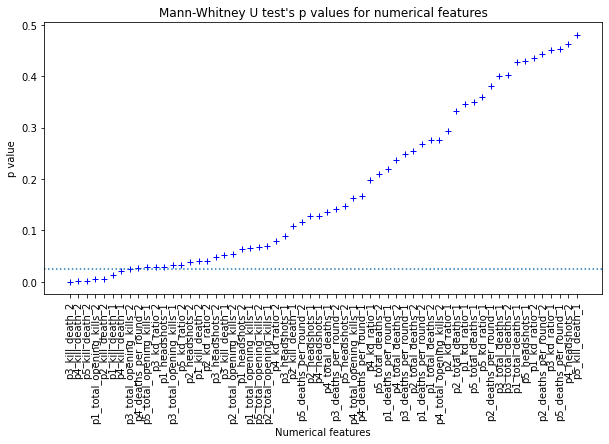

In [34]:
plt.figure(figsize=(10,5))
plt.plot(pmw[mworder],"b+")
plt.xticks(range(len(final_train.iloc[:,:-2].columns)), np.array(final_train.iloc[:,:-2].columns)[mworder],rotation=90)
plt.axhline(0.025,linestyle=":")
plt.title("Mann-Whitney U test's p values for numerical features")
plt.xlabel("Numerical features")
plt.ylabel("p value")
plt.show()

In [35]:
print("Средние значений данных признаков отличаются значимо:",[x[0] for x in zip(final_train.iloc[:,:-2].columns,pmw) if x[1]<0.025])

Средние значений данных признаков отличаются значимо: ['p1_total_opening_kills_2', 'p3_total_opening_kills_2', 'p1_kill_death_1', 'p4_kill_death_1', 'p2_kill_death_2', 'p3_kill_death_2', 'p4_kill_death_2', 'p5_kill_death_2']


Мы видим, что парамеры по которым сильно отличаются данные при 0 и 1, это параметр _kill_death_ и _total_opening_kills_

Проверим уровень корреляции между Картой и who_win

In [36]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [37]:
cat_features = ['map_name']

In [38]:
cr_val_matrix=np.ones((len(cat_features)+1,len(cat_features)+1))
cr_val_matrix[np.triu_indices(len(cat_features)+1,1)]=[cramers_stat(pd.crosstab(final_train[fea[0]],final_train[fea[1]]).values) 
                                                   for fea in itertools.combinations(cat_features+["who_win"],2)]
cr_val_matrix=cr_val_matrix+cr_val_matrix.T-1
cr_val_matrix

array([[1.        , 0.10648961],
       [0.10648961, 1.        ]])

Имеют слабую корреляцию (0.1)

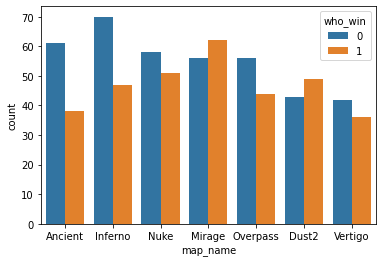

In [39]:
sns.countplot(x='map_name', data=final_train, hue="who_win")  
plt.show()    

In [40]:
set(final_train['map_name']),set(final_test['map_name'])

({'Ancient', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Overpass', 'Vertigo'},
 {'Ancient', 'Dust2', 'Inferno', 'Mirage', 'Nuke', 'Overpass', 'Vertigo'})

Сделаем one-hot кодирование

In [41]:
map_dummies_train = pd.get_dummies(final_train['map_name'])
map_dummies_test = pd.get_dummies(final_test['map_name'])

In [42]:
final_train = pd.concat((final_train, map_dummies_train), axis=1)
final_train = final_train.drop(['map_name'], axis=1)

In [43]:
final_test = pd.concat((final_test, map_dummies_test), axis=1)
final_test = final_test.drop(['map_name'], axis=1)

In [44]:
col_test = final_train.columns.tolist()
col_test.remove('who_win')
final_test = final_test[col_test]
final_test.shape

(30, 67)

### Начинаем обучение

In [45]:
final_train = final_train.drop(zero_train['index'].values)
final_train.shape

(678, 68)

In [46]:
X_train = final_train.drop(['who_win'],axis = 1)
y_train=final_train['who_win']
X_test = final_test

In [47]:
X_train.shape,y_train.shape

((678, 67), (678,))

Зададим максимальные значения параметров и будем подбирать модель с помощью кросс валидации

In [48]:
max_depth_params = 5
learning_rate_params = 0.1
n_estimators_params = 300
valid_size = 0.25
n_split_param = 10
max_evals=250
random_num = 42

Создаем функцию для подбора параметров

In [49]:
global score_all,sc
score_all = []
sc = []
def wraper_v1(X, Y, max_depth, learning_rate, n_estimators, 
           max_evals, size, n_split,random_pr,
           objective = 'binary',num_class = 1,is_unbalance = True,verbosity = -1):
    def lg_huper(params):
        global score_all,sc
        params = {
                'max_depth': int(params['max_depth']),
            'n_estimators': int(params['n_estimators']),
            'learning_rate': learning_rate,
            'reg_alpha': float(params['reg_alpha']),
        "objective": objective,
                'num_class': num_class,
                    "metric": "auc",
                    'is_unbalance': is_unbalance,
                "verbosity": verbosity}
        X_train = X.reset_index().drop(['index'],axis = 1)
        y_train = Y.reset_index().drop(['index'],axis = 1)
        score = []
        sss = StratifiedShuffleSplit(n_splits=n_split, test_size=size, random_state=random_pr)
        sss.get_n_splits(X_train, y_train)
        for train_index, test_index in sss.split(X_train, y_train):
            X_train_1, X_test_1 = X_train.loc[train_index,:], X_train.loc[test_index,:]

            y_train_1, y_test_1 = y_train.loc[train_index,:], y_train.loc[test_index,:]
            train_data = lgb.Dataset(X_train_1, label=y_train_1)
            valid_data = lgb.Dataset(X_test_1, label=y_test_1)
            lg = lgb.train(params,train_data,valid_sets = [train_data,valid_data],verbose_eval = False
                          )
            
            valid_pred = lg.predict(X_test_1)
            score += [metrics.roc_auc_score(y_test_1,valid_pred)]
        score_all+=[score]
        score_final =np.mean(score)
        sc += [score_final]
        return -score_final

    space = {
            'max_depth': hp.quniform('max_depth', 2, max_depth, 1),
            "n_estimators":  hp.quniform('n_estimators', 10, n_estimators, 1),
            'learning_rate': hp.quniform('learning_rate', 0.001, learning_rate,0.001),
            'reg_alpha': hp.quniform('reg_alpha', 0, 1, 0.01),
    }
    rstate = np.random.RandomState(42)
    best = fmin(fn=lg_huper,
                 space=space,
                 algo=tpe.suggest,
                 max_evals=max_evals,
                 rstate=rstate)
    return best

In [50]:
best = wraper_v1(X_train, y_train, max_depth=max_depth_params, learning_rate=learning_rate_params,
            n_estimators=n_estimators_params,
            max_evals=max_evals, size = valid_size, n_split = n_split_param,random_pr = random_num)

100%|██████████████████████████████████████████████| 250/250 [02:25<00:00,  1.72trial/s, best loss: -0.578745305327584]


Параметры модели которые подобрались

In [51]:
best

{'learning_rate': 0.076,
 'max_depth': 2.0,
 'n_estimators': 300.0,
 'reg_alpha': 0.05}

In [52]:
best['objective']='binary'
best['num_class']=1
best['n_estimators'] =  best['n_estimators'].astype(int)
best['max_depth'] =  best['max_depth'].astype(int)
best['is_unbalance'] = True
best['verbosity'] = -1
best['metric'] = 'auc'

Лучшее среднее значение roc_auc для набора параметров

In [53]:
max(sc)

0.578745305327584

Значение на всех валидационных наборах для лучших параметров

In [54]:
score_all[sc.index(max(sc))]

[0.5992488524134094,
 0.5794964529141745,
 0.5765753234107664,
 0.6113506746418139,
 0.5947976074558353,
 0.4876895256642092,
 0.5913200723327305,
 0.5633606899429684,
 0.5726804840728891,
 0.6109333704270414]

Обучаем нашу модель

In [55]:
train_data = lgb.Dataset(X_train, label=y_train)
param = best
bst= lgb.train(param, train_data)
y_test_predict_lgbm = bst.predict(X_test)
y_train_predict_lgbm = bst.predict(X_train)

Попробуем получить результаты для наших параметров на кросс-валидации

In [56]:
cv = StratifiedShuffleSplit(n_splits=10)
clf = LGBMClassifier(
learning_rate= best['learning_rate'],
max_depth= best['max_depth'],
n_estimators=best['n_estimators'],
reg_alpha= best['reg_alpha'],
objective= best['objective'],
num_class=best['num_class'],
    
is_unbalance= best['is_unbalance'],
verbosity= best['verbosity'],
metric= best['metric']
)

In [57]:
%%time
cval_score = model_selection.cross_validate(clf,  X_train, y_train,
                                          scoring =["roc_auc","precision",'recall'],return_train_score=True,cv = 10)

Wall time: 501 ms


In [58]:
print("Lightgbm кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("Lightgbm кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))

Lightgbm кросс-валидация train: 	roc_auc:0.99	precision:0.95	recall:0.94
Lightgbm кросс-валидация test: 	roc_auc:0.6	precision:0.55	recall:0.58


Теперь попробуем отколибровать наши коэффициенты

In [59]:
y_means, proba_means = calibration_curve(y_train, y_train_predict_lgbm, n_bins = 50)

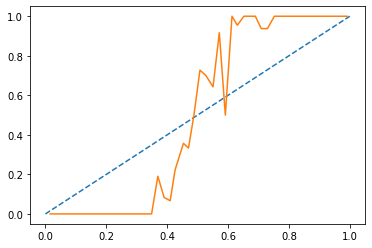

In [60]:
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')

plt.plot(proba_means, y_means)

In [61]:
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic',
                                         cv=cv
#                                         cv = 10
                                       )
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LGBMClassifier(is_unbalance=True,
                                                     learning_rate=0.076,
                                                     max_depth=2, metric='auc',
                                                     n_estimators=300,
                                                     num_class=1,
                                                     objective='binary',
                                                     reg_alpha=0.05,
                                                     verbosity=-1),
                       cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None),
                       method='isotonic')

Обучим модель

In [62]:
y_test_predict_lgbm_isotonic = calibrated_clf.predict_proba(X_test)[:,1]

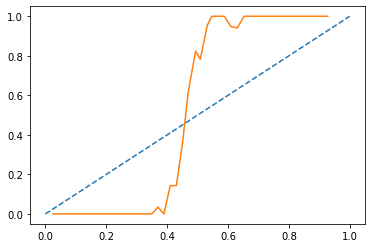

In [63]:
y_means_isot, proba_means_isot = calibration_curve(y_train, calibrated_clf.predict_proba(X_train)[:,1], n_bins = 50)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means_isot,y_means_isot)

In [64]:
%%time
cval_score = model_selection.cross_validate(calibrated_clf,  X_train, y_train,
                                          scoring =["roc_auc","precision",'recall'],return_train_score=True,cv = 10)

Wall time: 4.26 s


In [65]:
print("Lightgbm_isoton кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("Lightgbm_isoton кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))

Lightgbm_isoton кросс-валидация train: 	roc_auc:0.99	precision:0.99	recall:0.87
Lightgbm_isoton кросс-валидация test: 	roc_auc:0.6	precision:0.57	recall:0.43


Мы видим, что колибровка данных дала хоть и не значителньые но улучшения в данных

Модель Random_Forest

In [66]:
%%time
cval_score = model_selection.cross_validate(ensemble.RandomForestClassifier(n_estimators=200),  X_train, y_train,
                                          scoring =["roc_auc","precision",'recall'],return_train_score=True,cv = 10)

Wall time: 4.63 s


In [67]:
fr=ensemble.RandomForestClassifier(n_estimators=200)
fr.fit(X_train,y_train)
Y_train_predict_rf=fr.predict_proba(X_train)
Y_test_predict_rf=fr.predict_proba(X_test)

In [68]:
print("RandomForestClassifier кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("RandomForestClassifier кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))

RandomForestClassifier кросс-валидация train: 	roc_auc:1.0	precision:1.0	recall:1.0
RandomForestClassifier кросс-валидация test: 	roc_auc:0.59	precision:0.52	recall:0.44


Логистическая регрессия

In [69]:
%%time
from sklearn.linear_model import LogisticRegression
cval_score = model_selection.cross_validate(LogisticRegression(penalty = 'l2',solver ='liblinear',random_state=0),  X_train, y_train,
                                          scoring =["roc_auc","precision",'recall'],return_train_score=True,cv = 10)

Wall time: 498 ms


In [70]:
print("Logistic кросс-валидация train: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['train_roc_auc']),
                                                                                  np.mean(cval_score['train_precision']),
                                                                                  np.mean(cval_score['train_recall'])))
print("Logistic кросс-валидация test: \troc_auc:{:.2}\tprecision:{:.2}\trecall:{:.2}".format(np.mean(cval_score['test_roc_auc']),
                                                                                  np.mean(cval_score['test_precision']),
                                                                                  np.mean(cval_score['test_recall'])))

Logistic кросс-валидация train: 	roc_auc:0.75	precision:0.69	recall:0.63
Logistic кросс-валидация test: 	roc_auc:0.65	precision:0.6	recall:0.54


In [71]:
fr=LogisticRegression(penalty = 'l2',solver ='liblinear',random_state=0)
fr.fit(X_train,y_train)
Y_train_predict_lc=fr.predict_proba(X_train)
Y_test_predict_lc=fr.predict_proba(X_test)

### Как мы видим, лучшие три результата получились, для:  
- логистической регрессии  
- Градиентный бустинг с калибровкой коэфф.
- Обычный градиентный бустинг

Создадим прогнозы

In [72]:
data_test['logistic'] = Y_test_predict_lc[:,1]
data_test['boost_isoton'] = y_test_predict_lgbm_isotonic
data_test['boost'] = y_test_predict_lgbm

In [73]:
data_test.to_excel('test_predicts'+'.xlsx',index = False)